In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import utils 
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from einops import rearrange, reduce, repeat

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="test_20220707", id='lstm_ls_nonlinear4')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: acercyc. Use `wandb login --relogin` to force relogin


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:

class SpiralDataset(torch.utils.data.Dataset):
    def __init__(self, nTime=72, nBatch=128, seed=0):
        x = utils.SynthData.spiral(nTime, nBatch, seed)
        x_, y_ = utils.DataProcessing.cart2pol(x[:, :, 0], x[:, :, 1])
        x_ = repeat(x_, 'b t -> b t f', f=1)
        y_ = repeat(y_, 'b t -> b t f', f=1)
        x = np.concatenate([x, x_, y_], axis=2)
        self.data = x
              
        
    def __getitem__(self, idx):
        return self.data[idx, :, :]
        
    def __len__(self):
        return self.data.shape[0]
    
    
dataset_train = SpiralDataset(nTime=72, nBatch=128, seed=0)
dataset_val = SpiralDataset(nTime=72, nBatch=128, seed=1)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=False)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | TrajNet | 132 K 
----------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.528     Total estimated model params size (MB)
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of 

Training: 0it [00:00, ?it/s]

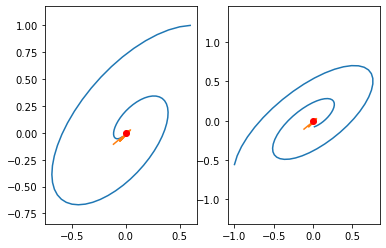

In [4]:
class TrajNet(nn.Module):
    def __init__(self, nHidden=8, nFeature=16, num_layers=8, dropout=0.1):
        super(TrajNet, self).__init__()
        self.nhidden = nHidden
        self.nFeature = nFeature

        # encoding
        # self.conv_enc = nn.Conv1d(5, nFeature, 1)
        self.encoder1 = nn.LSTM(4, 32, 4, dropout=dropout, batch_first=True)
        self.encoder2 = nn.LSTM(32, 32, 4, dropout=dropout, batch_first=True)
        self.encoder3 = nn.LSTM(32, nHidden, 4, dropout=dropout, batch_first=True)
        
        # hidden
        self.hidden = nn.Linear(nHidden, nHidden)
        # self.silu = nn.SiLU()
        # self.mu = nn.Linear(nFeature, nHidden)
        # self.log_var = nn.Linear(nFeature, nHidden)
        # self.alpha = torch.tensor(0.01)
                
        
        # decode
        self.decoder1 = nn.LSTM(nHidden, 32, 4, dropout=dropout, batch_first=True)
        self.decoder2 = nn.LSTM(32, 32, 4, dropout=dropout, batch_first=True)
        self.decoder3 = nn.LSTM(32, 2, 4, dropout=dropout, batch_first=True)
        self.dec_conv = nn.Conv1d(2, 2, 1)

        
        
    
    @staticmethod
    def positionEncoding(x):
        # x: b t f 
        nBatch = x.shape[0]
        nTime = x.shape[1]
        p = torch.arange(0, nTime).type_as(x)
        p = p / 300
        p = repeat(p, 't -> b t f', b=nBatch, f=1)
        x = torch.concat([x, p], dim=2)
        return x
    
    
    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5*log_var)  # standard deviation
        sample = torch.normal(mu, std).type_as(mu) # b f
        return sample
    
    @staticmethod
    def kl_loss_fun(mu, log_var):
        return (-0.5 * (1 + log_var - mu**2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        
        
    def forward(self, x):
        # x: b t f 
        nBatch = x.shape[0]
        nTime = x.shape[1]
        
        # --------------------------------- encoding --------------------------------- #
        x, _ = self.encoder1(x) # b t f
        x = F.relu(x)
        x, _ = self.encoder2(x) # b t f
        x = F.relu(x)
        x, _ = self.encoder3(x) # b t f
        x = F.relu(x)

        # ----------------------------- hidden bottleneck ---------------------------- #
        hidden = x[:, -1, :]
        hidden = F.relu(hidden)
        # hidden = self.hidden(hidden)
        # hidden = torch.tanh(hidden)
        # hidden = self.silu(hidden)
        # mu = self.mu(hidden)
        # mu = torch.tanh(mu)
        # log_var = self.log_var(hidden)
        # log_var = torch.tanh(log_var)
        # y = self.reparameterize(mu, log_var)
        # self.kl_loss = self.kl_loss_fun(mu, log_var)
        
        # --------------------------------- decoding --------------------------------- #
        y = repeat(hidden, 'b f -> b t f', t=nTime)
        y = F.relu(y)  
        y, _ = self.decoder1(y) # b t f
        y = F.relu(y)
        y, _ = self.decoder2(y) # b t f
        y = F.relu(y)
        y, _ = self.decoder3(y) # b t f
        y = rearrange(y, 'b t f -> b f t')
        y = self.dec_conv(y)
        y = rearrange(y, 'b f t -> b t f')
        return y 
        
        
class PL_model(pl.LightningModule):
    def __init__(self):
        super(PL_model, self).__init__()
        self.model = TrajNet()
        self.c = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.train()
        y = self.forward(batch)
        loss = torch.nn.functional.mse_loss(y, batch[:, :, 0:2]) # + self.model.kl_loss * self.model.alpha
        self.log('train_loss', loss)        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
        
    def training_epoch_end(self, training_step_outputs):        
        if self.c % 50 == 0:
            self.eval()
            
            # training set
            x = dataset_train[0:1]
            y = self.forward(torch.from_numpy(x).to(self.device).double())
            x = x.squeeze()
            y = y.squeeze()
            y = y.detach().cpu().numpy()
            ax[0].clear()
            ax[0].plot(x[:, 0], x[:, 1], '-')
            ax[0].plot(y[:, 0], y[:, 1], '-')
            ax[0].plot(0, 0, 'or')
            ax[0].axis('equal')
            
            # evaluation set
            x = dataset_val[0:1]
            y = self.forward(torch.from_numpy(x).to(self.device).double())
            x = x.squeeze()
            y = y.squeeze()
            y = y.detach().cpu().numpy()
            ax[1].clear()
            ax[1].plot(x[:, 0], x[:, 1], '-')
            ax[1].plot(y[:, 0], y[:, 1], '-')
            ax[1].plot(0, 0, 'or')
            ax[1].axis('equal')            
                        
            img = utils.Plot.fig2img(fig)
            wandb_logger.log_image('traj', [img])
            self.c = 0
        self.c += 1
          

fig, ax = plt.subplots(1, 2)
model = PL_model().double()
trainer = pl.Trainer(max_epochs=10000, 
                     logger=wandb_logger, 
                     log_every_n_steps=10,
                     accelerator='gpu', 
                     strategy='dp')
trainer.fit(model, dataloader_train)